# Capstone II: Craiglist Used Car Dataset

### Part 2: Exploratory Data Analysis (EDA)

Biman Mondal

Mar. 28, 2025

In [100]:
# Import numpy package
import numpy as np
# Import pandas package
import pandas as pd
# Import matplotlib package
import matplotlib.pyplot as plt
# Import the seaborn package
import seaborn as sns
# Import ydata-profiling package
# Import datetime
import datetime as dt

Original Dataset .csv file downloaded from Kaggle:
https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data
Wrangled data cleaned in: CapstoneTwo_CLCarDataset_DataWrangling.ipynb
The original dataset has been *halved* to speed up reading and processing.
The objective of this notebook is to describe the dataset and prepare it for modeling.
The ultimate goal is to create a model to predict the price of a vehicle given the other features of the dataset as the dependent variables.

In [101]:
vehicles = pd.read_csv('./data/wrangled_vehicles.csv', index_col=0)
vehicles.set_index('id', inplace=True)

### Configure Dataframe

In [102]:
# Fix the date to be year-month-day format
vehicles['posting_date']=pd.to_datetime(vehicles['posting_date'],utc=True)
vehicles['posting_date']=vehicles['posting_date'].dt.date

In [103]:
# Drop URL, region_url, VIN, image_url, description
# Drop URL's because they won't be used
# Drop VIN because it does not affect price
vehicles.drop(['url','region_url','VIN','size','image_url',\
               'description','paint_color'], axis=1, inplace=True)

In [104]:
print(vehicles['type'].unique())
print(vehicles['cylinders'].unique())
#myind = vehicles['type']=="other"
#vehicles.loc[myind,["price","type","manufacturer","model"]]

['mini-van' 'pickup' 'SUV' 'sedan' 'hatchback' 'other' nan 'offroad'
 'truck' 'convertible' 'coupe' 'wagon' 'bus' 'van']
['6 cylinders' '8 cylinders' nan '4 cylinders' 'other' '10 cylinders'
 '5 cylinders' '3 cylinders' '12 cylinders']


In [105]:
# Drop Bus type from the dataframe
vehicles = vehicles[vehicles['type']!="bus"]
print(vehicles['type'].unique())

# Replace mini-van as van and truck as pickup
vehicles.loc[vehicles['type']=='mini-van','type'] = 'van'
vehicles.loc[vehicles['type']=='truck','type'] = 'pickup'

print(vehicles['type'].unique())

['mini-van' 'pickup' 'SUV' 'sedan' 'hatchback' 'other' nan 'offroad'
 'truck' 'convertible' 'coupe' 'wagon' 'van']
['van' 'pickup' 'SUV' 'sedan' 'hatchback' 'other' nan 'offroad'
 'convertible' 'coupe' 'wagon']


In [106]:
# Drop "cylinders" to plot vehicle engine size
vehicles['cylinders'] = vehicles['cylinders'].str.replace(' cylinders', '', regex=False)
# Convert data to number
vehicles['cylinders'] = pd.to_numeric(vehicles['cylinders'], errors='coerce')
# Replace NAN's to median
vehicles['cylinders'] = vehicles['cylinders'].fillna(vehicles['cylinders'].median())


In [107]:
vehicles['cylinders'] = vehicles['cylinders'].astype('int')

In [108]:
# Assume fuel NA are gas, since most of the vehicles are gasoline engines
print(vehicles['fuel'].unique())
vehicles['fuel'] = vehicles['fuel'].fillna('gas')
print(vehicles['fuel'].unique())
# Convert fuel to numerical code
fuel_map = {'gas': 0, 'diesel': 1, 'hybrid': 2, 'electric': 3, 'other': 4}
vehicles['fuel_code'] = vehicles['fuel'].map(fuel_map)
#vehicles['fuel_code'] = pd.factorize(vehicles['fuel'])[0]
print(vehicles['fuel_code'].unique())


['gas' 'other' 'diesel' 'hybrid' nan 'electric']
['gas' 'other' 'diesel' 'hybrid' 'electric']
[0 4 1 2 3]


In [109]:
# Drop vehicles with title with 'parts only' or 'salvage'
myfilt = ((vehicles['title_status'].isin(["salvage"])) | (vehicles['title_status'].isin(['parts only'])))
vehicles = vehicles.loc[~myfilt,:]
vehicles['title_status'].unique()


array(['clean', 'lien', 'rebuilt', nan, 'missing'], dtype=object)

In [110]:
# Drop Salvage in condition
vehicles = vehicles[~vehicles['condition'].isin(['salvage'])]
print(f"There are {vehicles['condition'].isna().sum()} Nan's.")
print([vehicles['condition'].unique()])
# Replace NaN's with 
vehicles['condition'] = vehicles['condition'].fillna('good')
#print([vehicles['condition'].unique()])

There are 54456 Nan's.
[array(['excellent', 'good', 'fair', nan, 'like new', 'new'], dtype=object)]


In [111]:
condition_map = {'new':0,'like new':1,'excellent':2,'good':3,'fair':4 }
vehicles['condition_code'] = vehicles['condition'].map(condition_map)
# vehicles['condition'].hist()
# plt.show()

In [112]:
#vehicles.head().T

In [113]:
# Get the data information
vehicles.info()
rows_cols = vehicles.shape

<class 'pandas.core.frame.DataFrame'>
Index: 141981 entries, 7313406529 to 7301591140
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   region          141981 non-null  object 
 1   price           141981 non-null  int64  
 2   year            141981 non-null  int64  
 3   manufacturer    136683 non-null  object 
 4   model           140333 non-null  object 
 5   condition       141981 non-null  object 
 6   cylinders       141981 non-null  int32  
 7   fuel            141981 non-null  object 
 8   odometer        141188 non-null  float64
 9   title_status    139279 non-null  object 
 10  transmission    141352 non-null  object 
 11  drive           98714 non-null   object 
 12  type            111234 non-null  object 
 13  county          110345 non-null  object 
 14  state           141981 non-null  object 
 15  lat             141981 non-null  float64
 16  long            141981 non-null  float64
 17  po

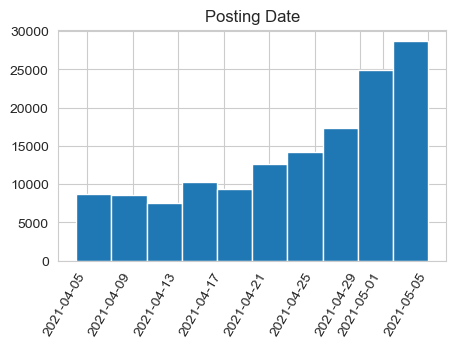

In [114]:
fig, ax1 = plt.subplots(figsize=(5,3))
plt.hist(vehicles["posting_date"])
labels = ax1.get_xticklabels()
vals = ax1.get_xticks()
ax1.xaxis.set_ticks(vals)
ax1.set_xticklabels(labels, rotation=60, ha='right')
plt.grid(True)
plt.title('Posting Date')
plt.show()

# Looks like most of the posts were scraped from Craigslist from April and May of 2021

### Price Histogram and CDF

In [115]:
# Drop all prices that are null or less than 100
myind = (vehicles["price"] != 0) & (vehicles["price"] >= 100)
vehicles = vehicles[myind]

In [116]:
#print(np.isinf(vehicles['price']).sum())
pd.set_option('display.float_format', lambda x: '%.0f' % x)
vehicles['price'].describe()

count   140768
mean     19114
std      15191
min        100
25%       7500
50%      15590
75%      27988
max     347999
Name: price, dtype: float64

There are 0 vehicles with nan price.
There are 0 vehicles with zero price.
There are 201 vehicles with price greater than $100,000.


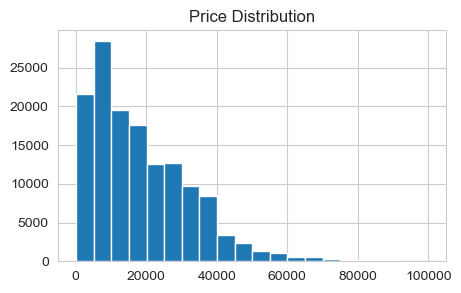

In [117]:
print(f"There are {vehicles[vehicles['price'].isna()].shape[0]} vehicles with nan price.")
print(f"There are {vehicles[vehicles['price']==0].shape[0]} vehicles with zero price.")
print(f"There are {vehicles[vehicles['price']>100000].shape[0]} vehicles with price greater than $100,000.")

myind= vehicles["price"]<100000
#print(vehicles.loc[myind,"odometer"].count())
#print(vehicles.loc[myind,"odometer"].head())
fix, ax = plt.subplots(figsize=(5,3))
plt.hist(vehicles.loc[myind,"price"],bins=20)
#ax.set_title('Vehicle Odometer')
plt.title('Price Distribution')
plt.grid(True)
plt.show()

In [118]:
# High price
high_price = vehicles.loc[vehicles["price"] > 100000,\
                          ['price','year','manufacturer','model']]
high_price.head(5)
print(f"There are {high_price.shape[0]} cars over $100k.")

There are 201 cars over $100k.


C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


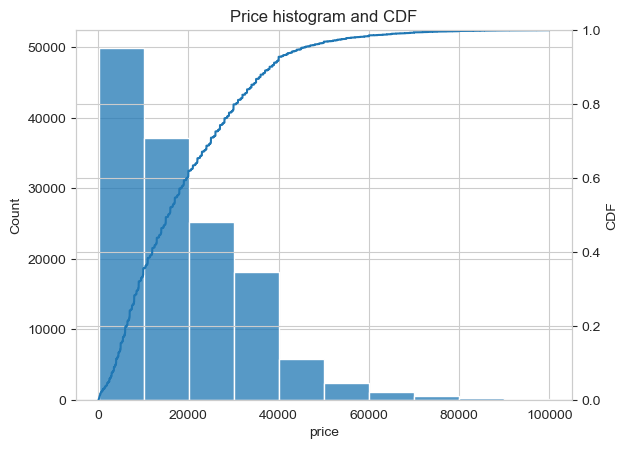

In [119]:
fig, ax1 = plt.subplots()
#myind = vehicles['price'].notnull()
#price = vehicles.loc[myind,'price']
# Plot histogram of price
sns.histplot(vehicles.loc[vehicles['price']<=100000,'price'],bins=10,ax=ax1)
# Plot CDF on second axis
ax2=ax1.twinx()
sns.ecdfplot(vehicles.loc[vehicles['price']<=100000,'price'])
ax2.set_ylabel('CDF')
plt.grid(True)
plt.title('Price histogram and CDF')
plt.show()

### Manufacturered Year Histograms


In [120]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
vehicles['year'].describe()

count   140768
mean      2011
std         10
min       1900
25%       2008
50%       2013
75%       2017
max       2022
Name: year, dtype: float64

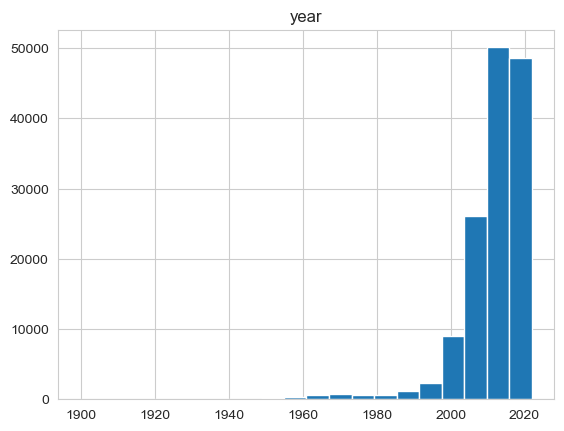

In [121]:
year = vehicles['year']
ax=vehicles[['year']].hist(bins=20,label=['Year'],grid=True)
plt.show()

There are 2916 vehicles older than 1980.


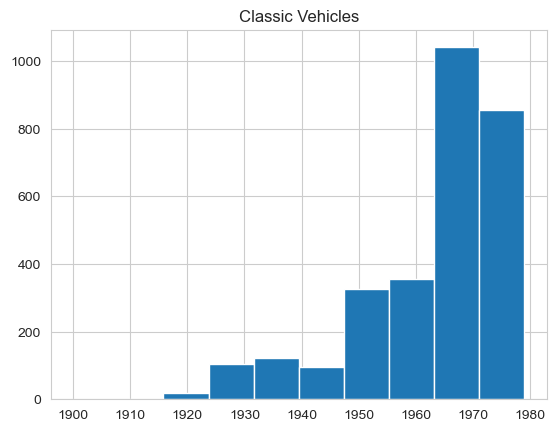

In [122]:
older_vehicle = vehicles[vehicles['year']<1980]
#print(older_vehicle[["price","year","manufacturer","model"]].head())
print(f"There are {older_vehicle.shape[0]} vehicles older than 1980.")
ax=older_vehicle[["year"]].hist(grid=True)
plt.title('Classic Vehicles')
plt.show()

### Odometer Histograms
The vehicle odometer distribution looks to be centered around 100k miles and skews right.

In [123]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
print(vehicles['odometer'].describe())
pd.reset_option('display.float_format')

count     139978
mean       98489
std       198420
min            0
25%        38311
50%        87332
75%       135528
max     10000000
Name: odometer, dtype: float64


There are 790 vehicles with nan odometer.
There are 367 with zero miles.
There are 509 with greater than 400,000 miles.


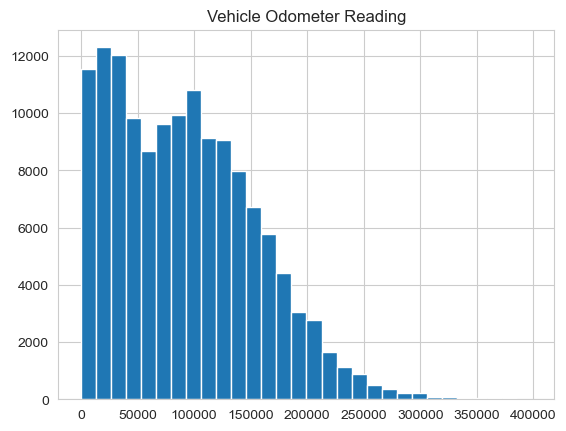

In [124]:
print(f"There are {vehicles[vehicles['odometer'].isna()].shape[0]} vehicles with nan odometer.")
print(f"There are {vehicles[vehicles['odometer']==0].shape[0]} with zero miles.")
print(f"There are {vehicles[vehicles['odometer']>400000].shape[0]} with greater than 400,000 miles.")
#print(len(vehicles["odometer"].index))
#print(vehicles["odometer"].isna().sum())
myind= (vehicles["odometer"]>0) & (vehicles["odometer"]<400000)
#print(vehicles.loc[myind,"odometer"].count())
#print(vehicles.loc[myind,"odometer"].head())
fix, ax = plt.subplots()
plt.hist(vehicles.loc[myind,"odometer"], bins=30)
plt.grid(True)
ax.set_title('Vehicle Odometer Reading')
plt.show()
# Drop vehicles with odometer greater than 350k
vehicles = vehicles[vehicles["odometer"]<350000]

### Use year and condition to fill NaN rows in odometer column

In [125]:
# Fill in odometer reading by looking up Lcondition and year of vehicle

# [new, like new, excellent, good, fair]
# [2021-2020, 2020-2018, ]
# Find 'condition' and 'year' missing
#myfilt = ((vehicles['odometer']<50) & (vehicles['condition'].isna()))
#foo = vehicles[myfilt]
#foo.head(5)
median_per_group = vehicles[vehicles['odometer']!=0].groupby(['year','condition'])['odometer'].median()

def replace_zero(row):
    if row['odometer'] == 0 or np.isnan(row['odometer']):
        condition = row['condition'] if pd.notna(row['condition']) else 'good'
        key = (row['year'], condition)
        if key in median_per_group:
            return median_per_group[key]
        elif row['year'] :
            return 0
    else: 
        return row['odometer']
vehicles['odometer'] = vehicles.apply(replace_zero, axis=1)



In [126]:
print(f"There are {vehicles[vehicles['odometer'].isna()].shape[0]} rows with nan odometer.")
print(f"There are {vehicles[vehicles['odometer']==0].shape[0]} rows with zero odometer.")

There are 0 rows with nan odometer.
There are 0 rows with zero odometer.


### Top 10 Regions & Manufacturers

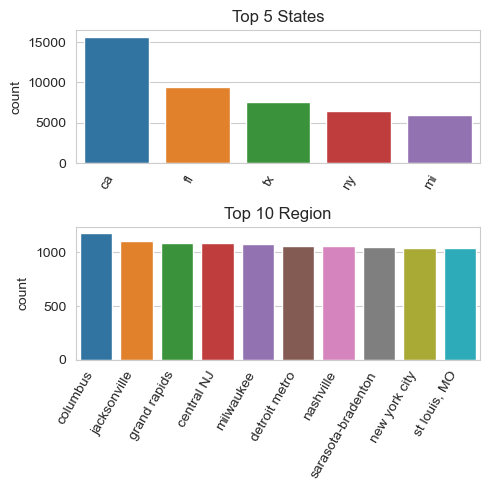

In [127]:
# Make subplots
fig, axes = plt.subplots(2,1, figsize=(5, 5))

# Plotting the percentage distribution of a single categorical variable
top5_state_ind = vehicles['state'].value_counts().nlargest(5).index
# Filter the DataFrame to include only the top 10 categories
top5_state = vehicles[vehicles['state'].isin(top5_state_ind)]
ax = sns.countplot(data=top5_state, x='state',order=top5_state_ind,ax=axes[0])
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=60, ha='right')
ax.set_title("Top 5 States")
ax.set_xlabel("")

# Plotting the percentage distribution of a single categorical variable
top10_reg_ind = vehicles['region'].value_counts().nlargest(10).index
# Filter the DataFrame to include only the top 10 categories
top10_reg = vehicles[vehicles['region'].isin(top10_reg_ind)]
ax = sns.countplot(data=top10_reg, x='region',order=top10_reg_ind,ax=axes[1])
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=60, ha='right')
ax.set_title("Top 10 Region")
ax.set_xlabel("")

#
plt.tight_layout()
plt.show()

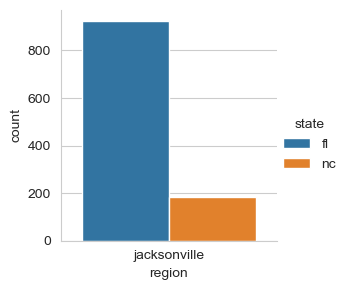

In [128]:
#fig, axis = plt.subplots(1, figsize=(4, 4))
#sns.set_style("whitegrid")
sns.catplot(x='region',data=vehicles[vehicles['region']=='jacksonville'],hue='state',kind="count",height=3)
plt.xticks(rotation=0)
plt.show()
# There are two jacksonville's that are being counted.
# And there are two columbus's that are being counted

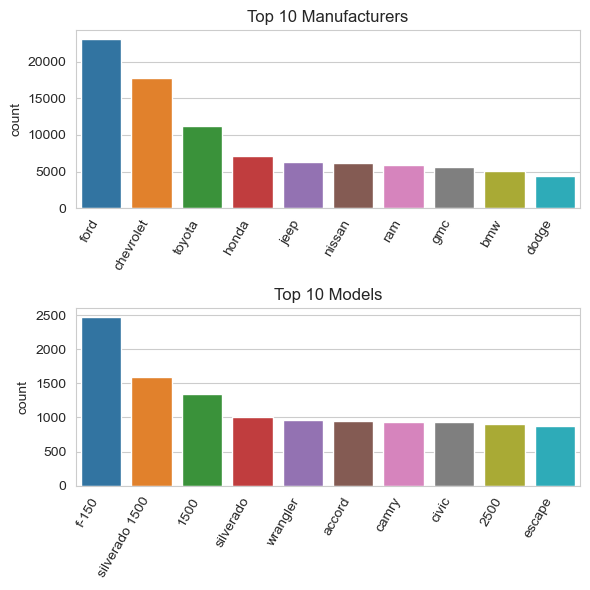

In [129]:
# Make subplots
fig, axes = plt.subplots(2,1, figsize=(6, 6))

# Plotting the percentage distribution of a single categorical variable
top10_manf_ind = vehicles['manufacturer'].value_counts().nlargest(10).index
# Filter the DataFrame to include only the top 10 categories
top10_manf = vehicles[vehicles['manufacturer'].isin(top10_manf_ind)]
# Plot
ax1 = sns.countplot(data=top10_manf, x='manufacturer',order=top10_manf_ind,ax=axes[0])
labels1 = ax1.get_xticklabels()
ax1.set_xticklabels(labels1, rotation=60, ha='right')
ax1.set_title("Top 10 Manufacturers")
ax1.set_xlabel("")


top_models_indices = vehicles['model'].value_counts().nlargest(10).index
top10_models = vehicles[vehicles['model'].isin(top_models_indices)]

ax2 = sns.countplot(data=top10_models, x='model',order=top_models_indices,ax=axes[1])
labels1 = ax2.get_xticklabels()
ax2.set_xticklabels(labels1, rotation=60, ha='right')
ax2.set_title("Top 10 Models")
ax2.set_xlabel("")

plt.tight_layout()
plt.show()

### Categorical Plots

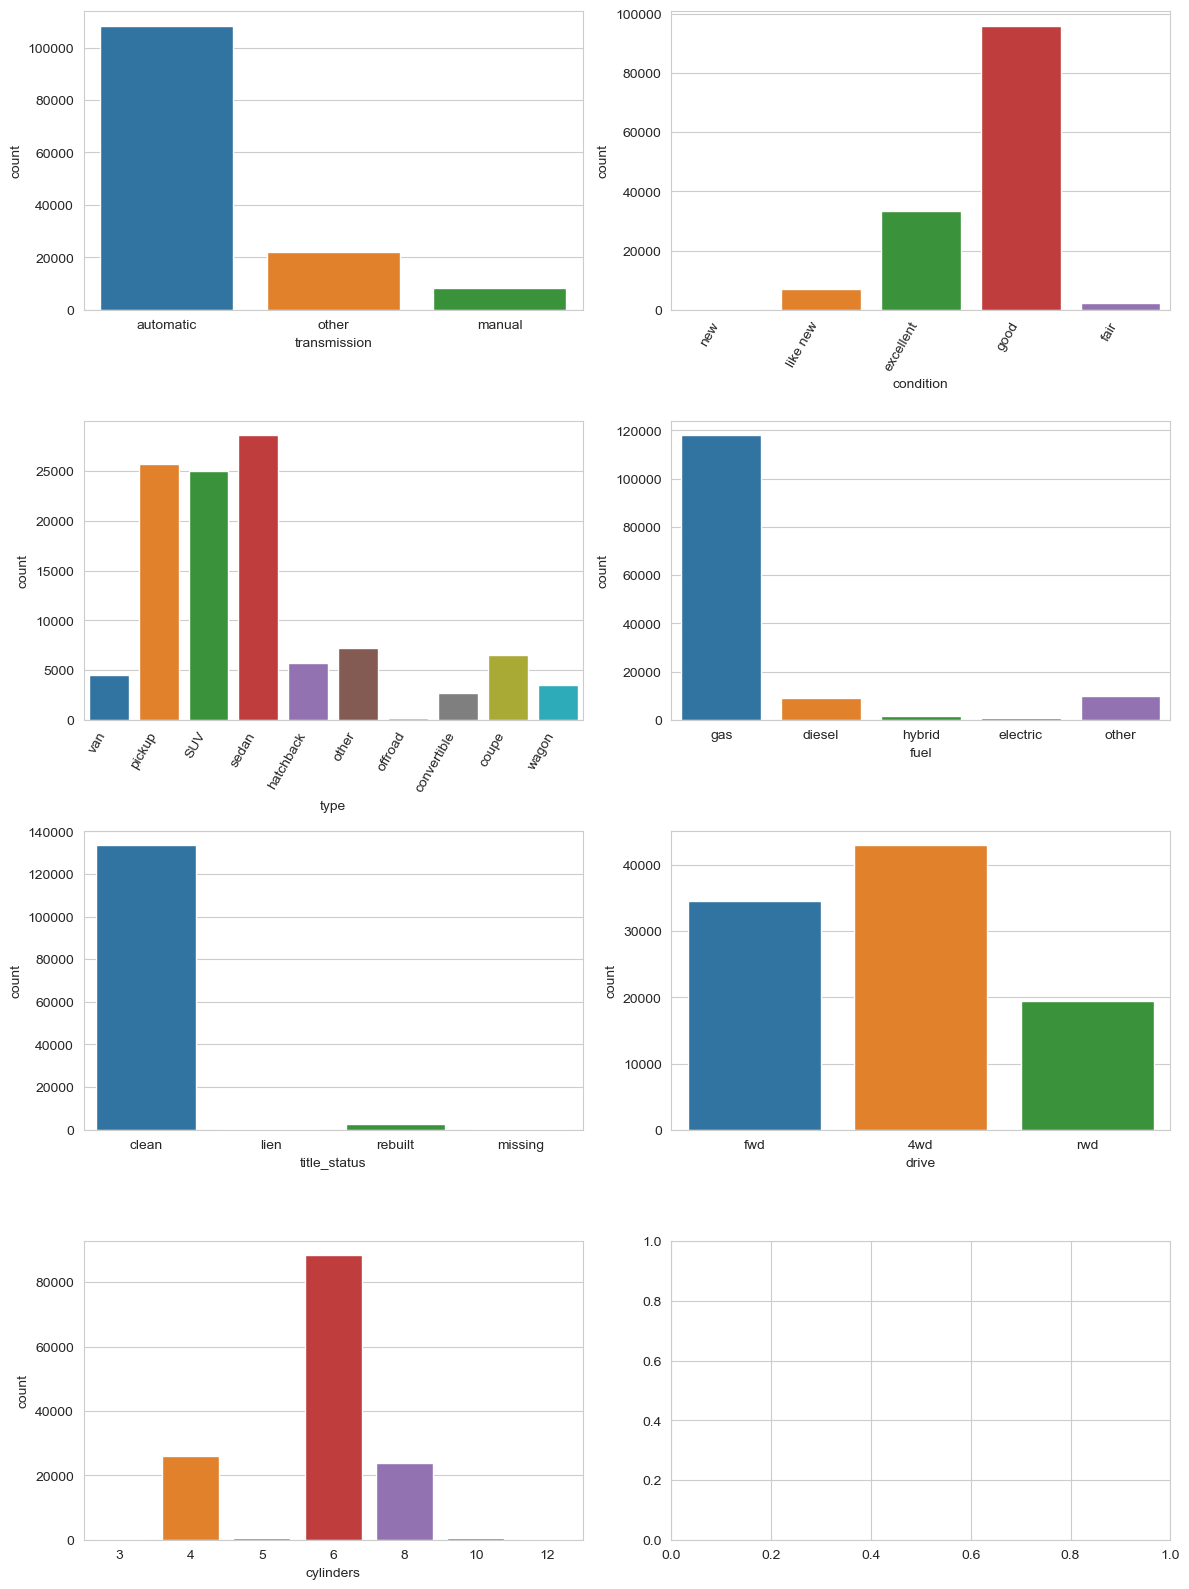

In [134]:
# Make subplots
fig, axes = plt.subplots(4,2, figsize=(12, 16))

# Plot Transmission
sns.countplot(data=vehicles, x='transmission', ax=axes[0,0])

# Plot Condition
cond_order = ["new","like new","excellent","good","fair"]
sns.countplot(x="condition",data=vehicles,order=cond_order,ax=axes[0,1])
labels = axes[0,1].get_xticklabels()
axes[0,1].set_xticklabels(labels, rotation=60, ha='right')

# Plot Vehicle Type
sns.countplot(x="type",data=vehicles,ax=axes[1,0])
labels = axes[1,0].get_xticklabels()
axes[1,0].set_xticklabels(labels, rotation=60, ha='right')

# Plot Vehice Fuel
sns.set_style("whitegrid")
fuel_order = ["gas","diesel","hybrid","electric","other"]
g=sns.countplot(x="fuel",data=vehicles,order=fuel_order,ax=axes[1,1])

# Plot Title Status
sns.countplot(x="title_status",data=vehicles,ax=axes[2,0])

# Plot Vehicle Drive
sns.countplot(x="drive",data=vehicles,ax=axes[2,1])

# Plot Cylinders
#cylin_order = ['3','4','5','6','8','10','12','other']
sns.countplot(x="cylinders",data=vehicles,ax=axes[3,0])

# Plot Paint Color
#sns.countplot(x="paint_color",data=vehicles,ax=axes[3,1])
#labels = axes[3,1].get_xticklabels()
#axes[3,1].set_xticklabels(labels, rotation=60, ha='right')

plt.tight_layout()
plt.show()

From the categorical plots above shows that the dataset has mostly automatic vehicles that are gas powered with clean titles. There are more 4wd than front wheel drive vehicles which is surprising. Additionally most of the vehicles are in excellent condition.

### Plot relationship between Price, Mileage, and Year

In [135]:
top_vehicles = vehicles['manufacturer'].value_counts()
top_10_price = vehicles.loc[vehicles['manufacturer'].isin(top_vehicles[:9].index),['manufacturer','price']]

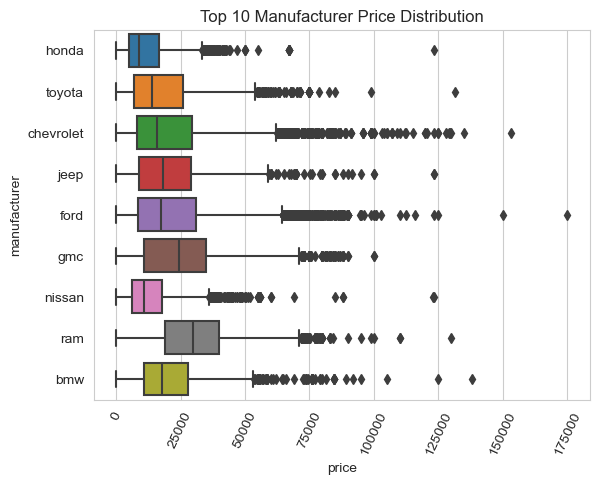

In [136]:
g=sns.boxplot(x=top_10_price['price'],
              y=top_10_price['manufacturer'])
plt.xticks(rotation=65)
plt.title('Top 10 Manufacturer Price Distribution')
plt.show()

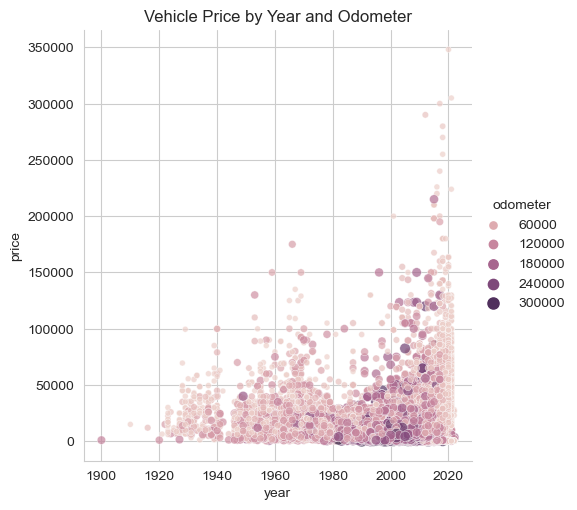

In [137]:
sns.relplot(x='year',
           y='price',
           data=vehicles,
           kind='scatter',
           hue = 'odometer',
           size='odometer',
           alpha=0.7)
plt.title('Vehicle Price by Year and Odometer')
plt.show()

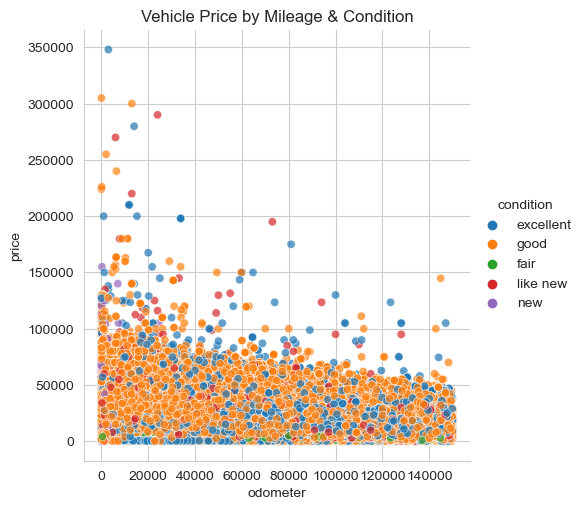

In [138]:
myind = vehicles['odometer']<150000

sns.relplot(x=vehicles.loc[myind,"odometer"],
           y=vehicles.loc[myind,"price"],
           kind='scatter',
           hue=vehicles.loc[myind,'condition'],
           alpha=0.7)
plt.title('Vehicle Price by Mileage & Condition')
plt.show()

### Factorize Columns

In [139]:
# Convert 
#vehicles.head(4).T

In [140]:
vehicles['drive'] = vehicles['drive'].fillna('fwd')

In [141]:
# Convert categorical columns to Numerical

columns_to_factorize = ['region','manufacturer', 'model','condition','fuel','title_status','transmission','drive','type']
fact_col_name=[col + '_code' for col in columns_to_factorize]
#print(fact_col_name)

for col, col_new in zip(columns_to_factorize,fact_col_name):
    vehicles[col_new], _ = pd.factorize(vehicles[col])

In [142]:
#vehicles.head().T

### Feature Pairplot and Correlation Heatmap

In [143]:
vehicles_sub1 = vehicles[["manufacturer_code","model_code","price","year",\
                          "odometer","cylinders","condition_code"]]
vehicles_sub1.head()

,manufacturer_code,model_code,price,year,odometer,cylinders,condition_code
id,,,,,,,
7313406529,0,0,14000,2012,95000.0,6,0
7312799035,1,1,31990,2013,55068.0,8,1
7312342811,1,2,22990,2012,37725.0,6,1
7312337810,2,3,26990,2014,63129.0,6,1
7312313815,3,4,33990,2017,34152.0,6,1


C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

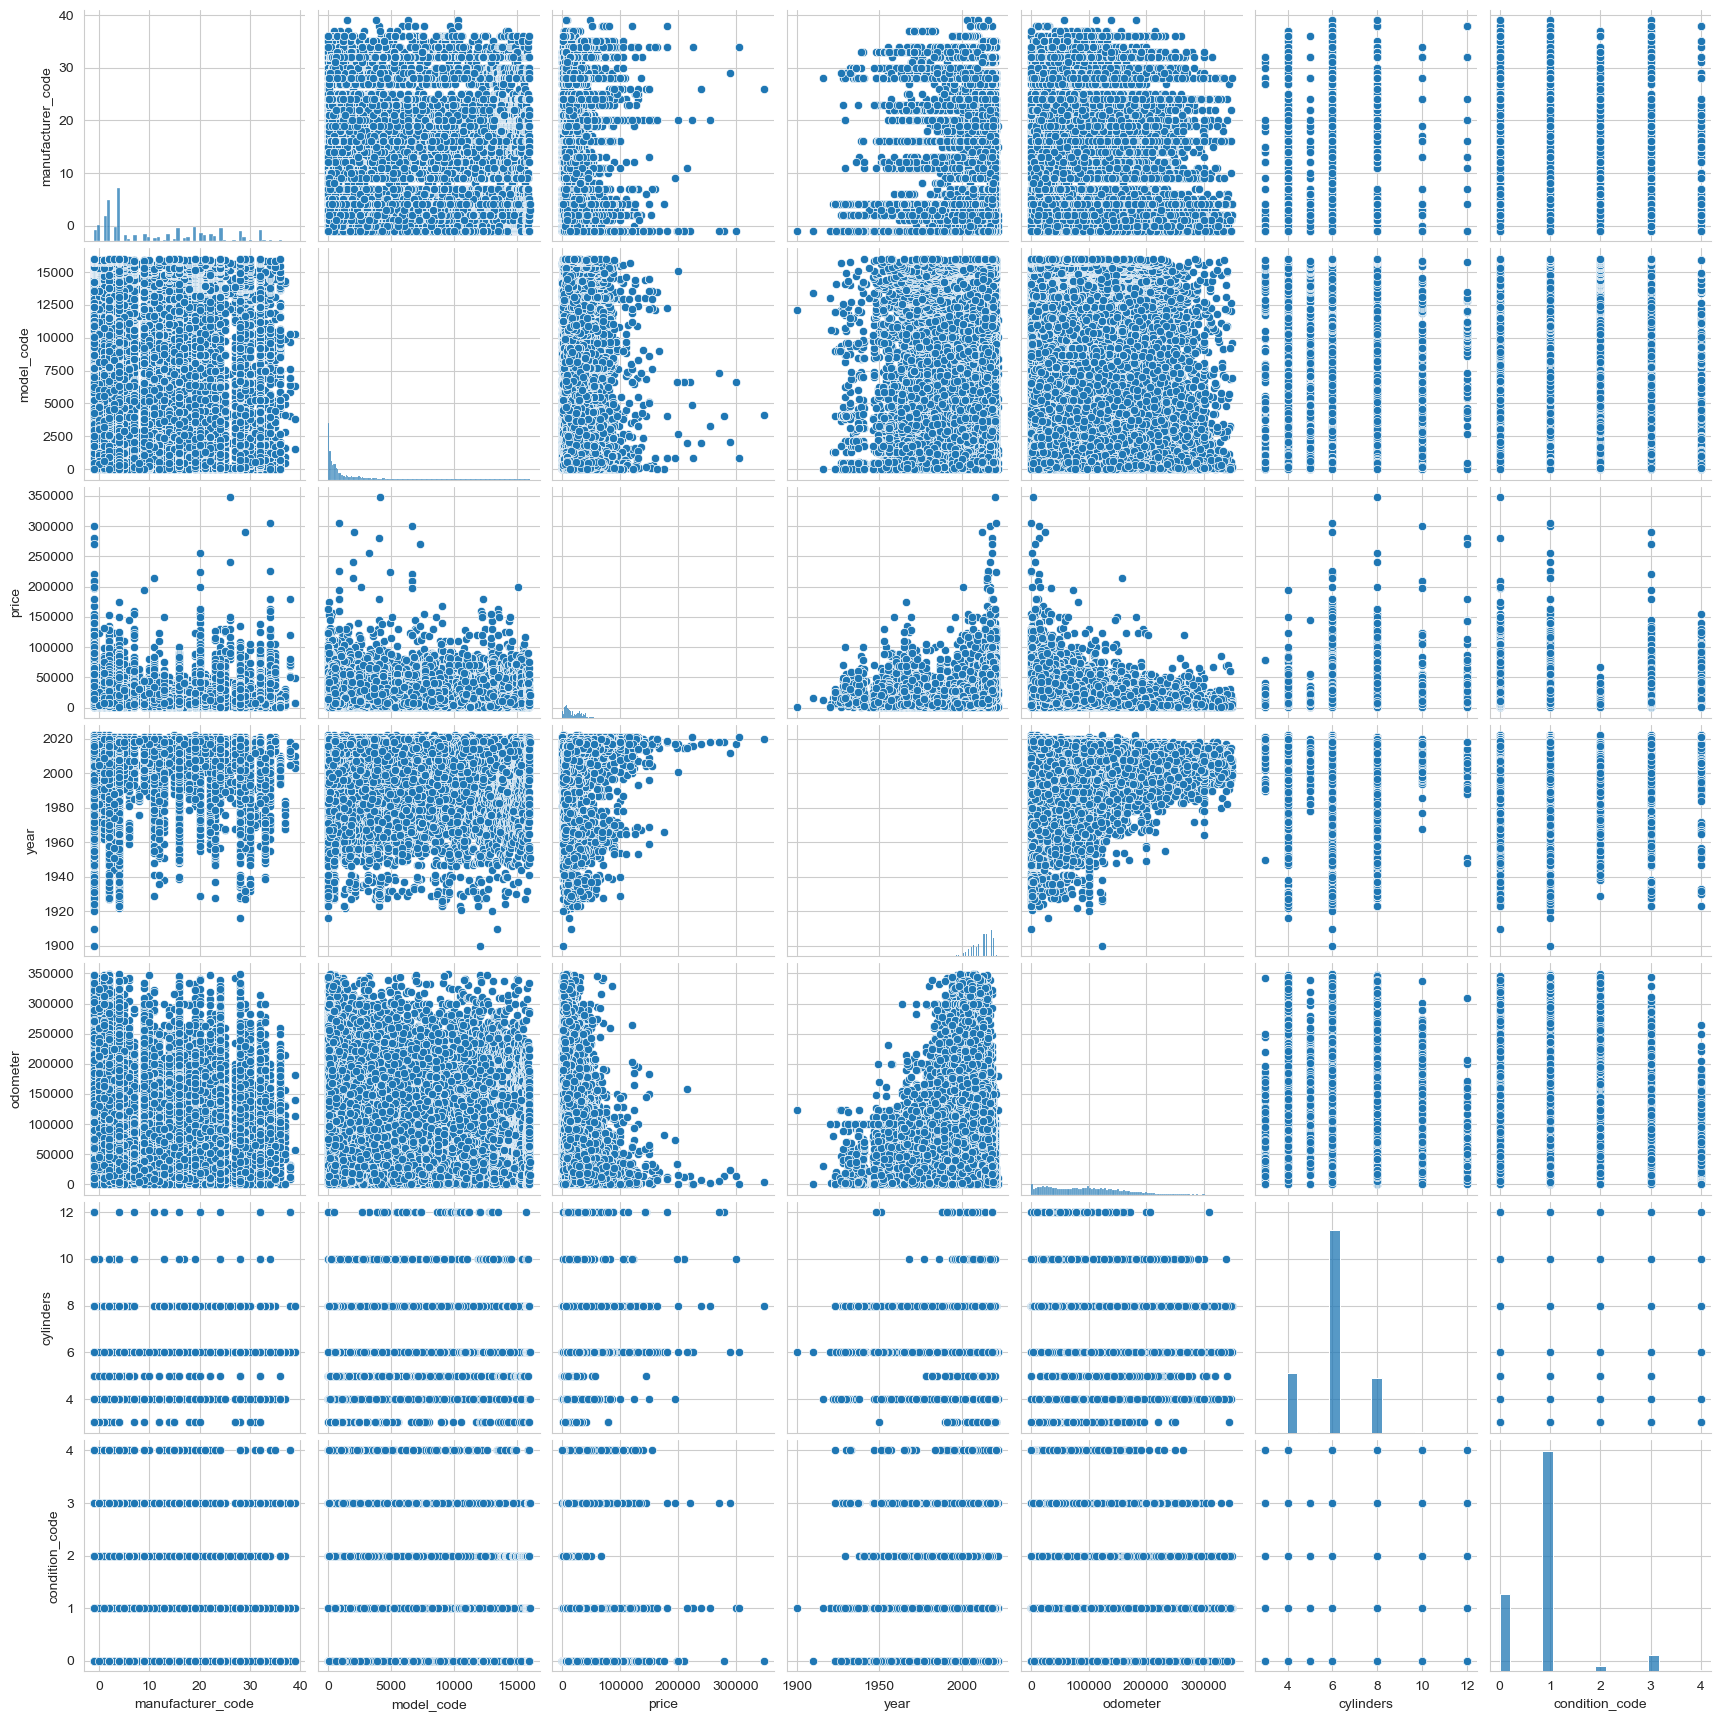

In [144]:
sns.pairplot(vehicles_sub1)
plt.show()

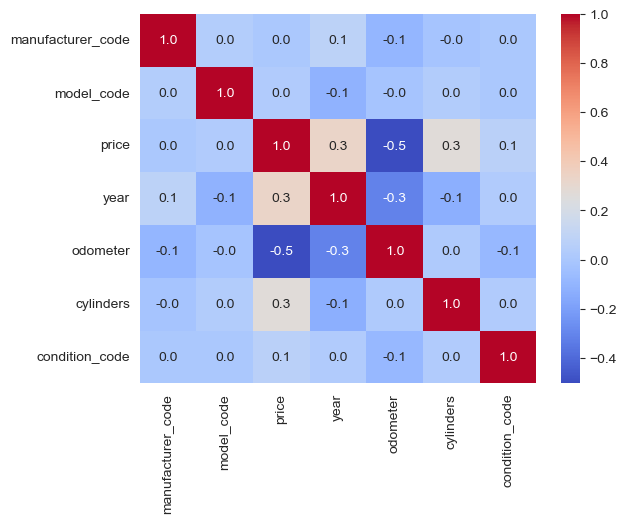

In [145]:
# Make a heatmap of the data 
sns.heatmap(vehicles_sub1.corr(), annot=True, fmt=".1f", cmap='coolwarm')
#plt.figure(figsize=(8, 8))
plt.show()

### Correlation Take-away
There is a clear inverse correlation between mileage and year with price. However, the factorized columns don't seem to show any real relationship to price. 

### Initial Regression Analysis

In [146]:
# Import regression modules
import statsmodels.api as sm

In [147]:
X = vehicles_sub1[["year","odometer","cylinders","condition_code"]]
#import statsmodels.api as sm
X = sm.add_constant(X)
m = sm.OLS(vehicles_sub1['price'],X).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                 2.145e+04
Date:                Thu, 17 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:23:08   Log-Likelihood:            -1.5052e+06
No. Observations:              139311   AIC:                         3.010e+06
Df Residuals:                  139306   BIC:                         3.010e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.542e+05   7224.342   -104.

## Summary

The columns not likely to be useful in predicting price have been dropped from the dataframe (image_url). The null and nan values have been removed as much as possible where necessary. In the mileage (odometer) column, the year and condition were used to provide the replace the null/nan values with the median.

Price, odometer, year, and cylinders (engine size) are the only numeric features in the dataset. The others are categorical and need to be modified using pd.factorize(). There are many rows of model section that is mistyped or mislabeled. 

The histograms show that the price skews right and has a median around 10k. There are very few vehicles above 100k. 
The histogram of the mileage shows that the there is a peak around 100k miles and skews right as well. There are very few vehicles above 150k miles. The manufactured year skews left with the median around 2011.  

Plotting the scatter of the price, the newer vehicles tend to be lower mileage and higher price. But there's no visual correlation. The sample regression analysis shows poor prediction of price with the chosen variables. Further work will be performed in the next section to improve the prediction. 
